## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [91]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import chain
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [3]:
with np.load('data/ncbi_02/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    decoder_target_data = data['decoder_target_data']
    token_index = data['token_index'].tolist()

In [4]:
print(.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)
print(token_index)

(4368, 3822, 4)
(4368, 3822, 4)
(4368, 3822, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


## Inference

In [5]:
model = keras.models.load_model("data/ncbi_02/model_256")
model.summary()

2021-10-05 17:42:53.539496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 17:42:53.539851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 17:42:53.545387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 17:42:53.545766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 17:42:53.546381: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 267264      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  267264      input_2[0][0]                    
                                                                 lstm[0][1]                   

In [6]:
latent_dim = 256

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [ state_h_enc, state_c_enc ]
encoder_model = keras.Model(encoder_inputs, encoder_states)

encoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 4)]         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 267264    
Total params: 267,264
Trainable params: 267,264
Non-trainable params: 0
_________________________________________________________________


In [8]:
decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape = (latent_dim,))
decoder_state_input_c = keras.Input(shape = (latent_dim,))
decoder_states_inputs = [ decoder_state_input_h, decoder_state_input_c ]

decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state = decoder_states_inputs
)

decoder_states = [ state_h_dec, state_c_dec ]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = keras.Model(
    [ decoder_inputs ] + decoder_states_inputs, [ decoder_outputs ] + decoder_states
)

decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  267264      input_2[0][0]                    
                                                                 input_3[0][0]              

In [9]:
# Reverse-lookup token index to decode sequences back to something readable.
reverse_char_index = dict((i, char) for char, i in token_index.items())
decode_seq = lambda seq: ''.join([ reverse_char_index[i] for i in np.argmax(seq, axis = 2)[0] ])

In [10]:
def decode_sequence(input_seq):

    output_seq = np.zeros_like(input_seq)
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, len(token_index)))
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    for i in range(encoder_input_data.shape[1]):
        
        output_token, h, c = decoder_model.predict([ target_seq ] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_token[0, -1, :])
        output_seq[0, i, sampled_token_index] = 1.0
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, len(token_index)))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
        
    return output_seq

In [94]:
def decode_sequence_batch(input_seqs):
    n_seqs = input_seqs.shape[0]

    output_seqs = np.zeros_like(input_seqs)
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seqs)
    
    # Generate empty target sequence of length 1.
    target_seqs = np.zeros((n_seqs, 1, len(token_index)))
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    for i in tqdm(range(encoder_input_data.shape[1])):
        
        output_token, h, c = decoder_model.predict([ target_seqs ] + states_value)

        # Sample a token
        sampled_token_indexes = np.squeeze(np.argmax(output_token, axis = 2))
        output_seqs[:, i, sampled_token_indexes] = 1.0
        
        # Update the target sequence (of length 1).
        target_seqs = np.zeros((n_seqs, 1, len(token_index)))
        target_seqs[:, 0, sampled_token_indexes] = 1.0

        # Update states
        states_value = [h, c]

    return output_seqs

In [95]:
output_seqs = decode_sequence_batch(encoder_input_data)

with open('data/ncbi_02/predicted_256.npy', 'wb') as f:
    np.save(f, output_seqs)
    
#     d = keras.losses.CategoricalCrossentropy()(target_seq, output_seq).numpy()
#     print(f"{i}. {d}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3822/3822 [12:09<00:00,  5.24it/s]


## Metrics

In [96]:
keras.losses.CategoricalCrossentropy()(decoder_target_data, output_seqs).numpy()

0.009855672

In [99]:
np.argmax(encoder_input_data, axis = 2)

array([[0, 3, 2, ..., 3, 0, 0],
       [0, 3, 2, ..., 3, 0, 0],
       [0, 3, 2, ..., 3, 0, 0],
       ...,
       [0, 3, 2, ..., 3, 0, 0],
       [0, 3, 2, ..., 3, 0, 0],
       [0, 3, 2, ..., 3, 0, 0]])

In [101]:
np.argmax(decoder_input_data, axis = 2)
#plt.show()

array([[0, 3, 2, ..., 3, 0, 0],
       [0, 3, 2, ..., 3, 0, 0],
       [0, 3, 2, ..., 3, 0, 0],
       ...,
       [0, 3, 2, ..., 3, 0, 0],
       [0, 3, 2, ..., 3, 0, 0],
       [0, 3, 2, ..., 3, 0, 0]])

In [123]:
mut01 = np.sum(
    (np.subtract(
        np.argmax(encoder_input_data, axis = 2), 
        np.argmax(decoder_input_data, axis = 2)
    ) != 0.0).astype(int), axis = 0)

In [124]:
mut02 = np.sum(
    (np.subtract(
        np.argmax(decoder_target_data, axis = 2), 
        np.argmax(output_seqs, axis = 2)
    ) != 0.0).astype(int), axis = 0)

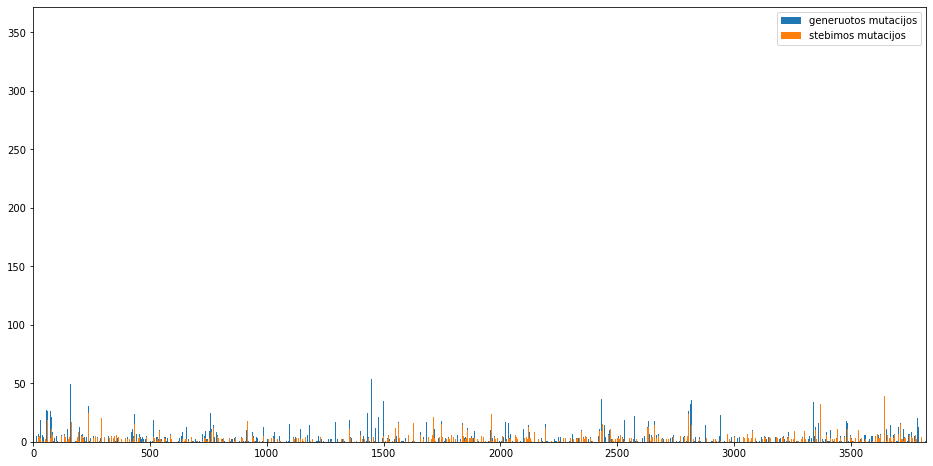

In [137]:
x_range = list(range(len(mut01)))
plt.bar(x_range, mut02, bottom = mut01, label = 'generuotos mutacijos')
plt.bar(x_range, mut01, label = 'stebimos mutacijos')
#plt.ylim(0, 200.0)
plt.xlim(0, len(mut01))
plt.legend()
plt.show()

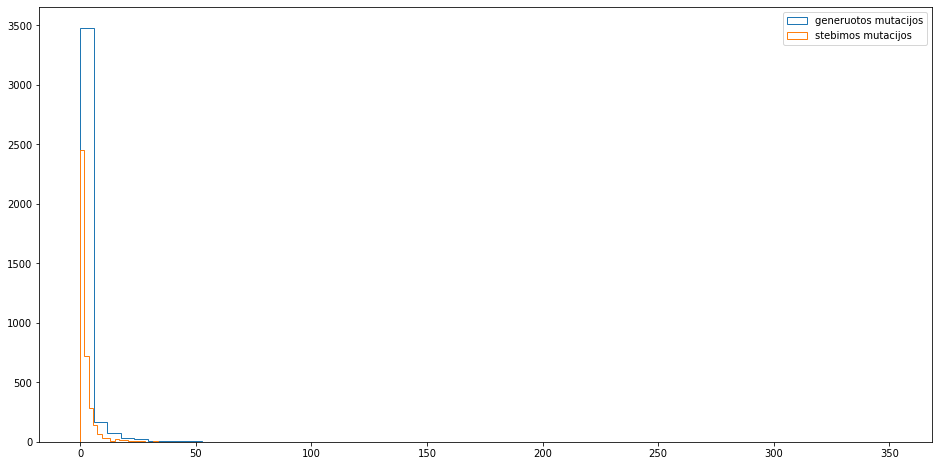

In [138]:
plt.hist(mut02, bins = 60, label = 'generuotos mutacijos', fill = False, histtype='step')
plt.hist(mut01, bins = 60, label = 'stebimos mutacijos', fill = False, histtype='step')
plt.legend()
plt.show()